In [297]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results, measure_smoothness_with_df, compute_rsquared
import torch
import torch.nn as nn
from tqdm.notebook import tqdm


from postprocessing.arima import smooth_nn_predictions_with_arima_auto, smooth_nn_predictions_with_arima


TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

# import os
# os.environ['PATH'] += ':/Users/leonardamsler/bin'
# plt.style.use('ieee.mplstyle')

## Loading and Preprocessing Data

### Loading Google Trends

In [298]:
TRAIN_PROPORTION = 0.9
MODE = "diff" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [299]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [300]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE,
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


## Simple Prediction Model

Using mps device


100%|██████████| 100/100 [00:01<00:00, 92.79it/s]


Final training loss: 0.01411503367125988
Final validation loss: 0.49500030279159546
Final validation R^2: 0.341994984856945
Best r squared: 0.36623771440346997 at epoch 58


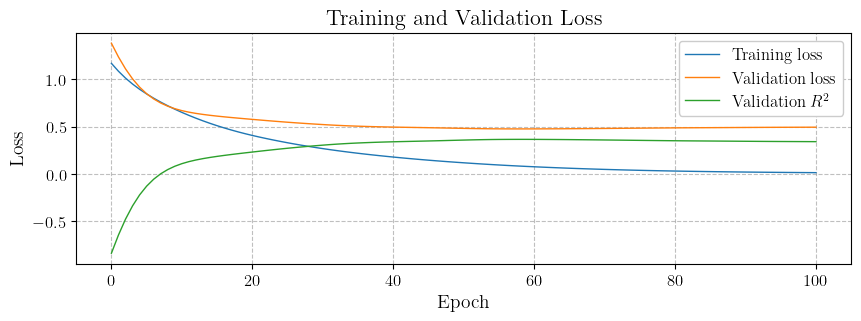

In [301]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

## High frequency predictions

In [302]:
# Predict for the high frequency data
device = get_device(False)
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [303]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [304]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions = predictions.drop_duplicates(subset=["date", "country"])

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

In [305]:
# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    #plt.fill_between(filtered_data["date"], filtered_data["y_pred_high_freq"] - 3 * filtered_data["stdv"], filtered_data["y_pred_high_freq"] + 3 * filtered_data["stdv"], alpha=0.2, color="blue")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

<function __main__.plot_by_country(selected_country)>

In [306]:
# Compute the smoothness of the predictions
predictions2 = predictions.copy()
predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results = measure_smoothness_with_df(predictions2)[1]
print(f"Smoothness loss: {smoothness_results}")

## Apply ARIMA smoothing

In [307]:
p = 1
d = 1
q = 1
adjusted_predictions = smooth_nn_predictions_with_arima(predictions, p, d, q)

In [308]:
def plot_by_country(selected_country):
    adjusted_filtered_data = adjusted_predictions[adjusted_predictions["country"] == selected_country]
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted", alpha=0.5)
    plt.plot(adjusted_filtered_data["date"], adjusted_filtered_data["y_pred_high_freq"], label="Adjusted Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [309]:
# Plot the adjusted predictions
interact(plot_by_country, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

<function __main__.plot_by_country(selected_country)>

In [310]:
# Compute the smoothness results
adjusted_predictions2 = adjusted_predictions.copy()
adjusted_predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
smoothness_results_adjusted = measure_smoothness_with_df(adjusted_predictions2)[1]
print(f"ARIMA Smoothness loss: {smoothness_results_adjusted}")

## Create scatter plot data (Rsquared and Smoothness)


In [311]:
# 1. We will create N_MODELS
# 2. We will train each model with a different seed
# 3. We will predict the high frequency data
# 4. Apply ARIMA for all combinaisons of parameters (p,d,q) from 0 to 3 (nb of models = 64)
# 5. For each combinaison, we will compute the medina smoothness / r squared on the validation data
# 6. Compute the median of r squared and smoothness for each combinaison

N_MODELS = 10
MAX_P = 10
MAX_D = 2
MAX_Q = 10
NB_COMB = MAX_P * MAX_D * MAX_Q
print(f"Total nb of combinaison: {NB_COMB}")

results = [] # map from config to a list of results (p, d, q) => [r_squared, smoothness]
for i in tqdm(range(N_MODELS)):
    model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=False,
                                                                       seed= SEED + i)

    y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
    y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})
    
    combinaisons = []
    for p in range(MAX_P):
        for d in range(MAX_D):
            for q in range(MAX_Q):
                combinaisons.append((p, d, q))

    for (p,q,d) in tqdm(combinaisons):

        # Merge the predictions with the true GDPs
        predictions = y_pred_high_freq_country.copy()
        predictions = predictions.merge(all_true_gdps_country, on=['date', "country"], how='left')
        predictions = predictions.drop_duplicates(subset=['date', 'country'])
        predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

        # Apply ARIMA
        adjusted_predictions = smooth_nn_predictions_with_arima(predictions, p, d, q)

        # Compute the smoothness of the predictions
        adjusted_predictions2 = adjusted_predictions.copy()
        adjusted_predictions2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
        (m1,m2,m3) = measure_smoothness_with_df(adjusted_predictions2)

        # Compute the R squared
        valid_pred = adjusted_predictions[(adjusted_predictions["date"] >= preprocessor.splitting_date) & (adjusted_predictions["y_true"].notna())]
        valid_pred_y = valid_pred["y_pred_high_freq"]
        valid_true_y = valid_pred["y_true"]
        r_squared = compute_rsquared(valid_true_y, valid_pred_y)

        if i == 0:
            results.append({'p': p, 'd': d, 'q': q, 'r_squared': [r_squared], 'smoothness': [m2], "predictions": [adjusted_predictions]})
        else:
            idx = [i for i, x in enumerate(results) if x['p'] == p and x['d'] == d and x['q'] == q][0]
            results[idx]['r_squared'].append(r_squared)
            results[idx]['smoothness'].append(m2)
            results[idx]['predictions'].append(adjusted_predictions)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [312]:
# Aggregate the ARIMA results, do the median of the all_pred
results_aggregated = []
for r in results:
    # Aggregate the ARIMA results, do the median of the all_pred
    all_pred_df = pd.concat(r['predictions'])
    all_pred_df = all_pred_df.groupby(['date', 'country']).median().reset_index()

    # Compute the smoothness result on the median predictions
    all_pred_df2 = all_pred_df.copy()
    all_pred_df2.rename(columns={"y_pred_high_freq": "data"}, inplace=True)
    smoothness_results_median = measure_smoothness_with_df(all_pred_df2)[1]

    # Compute the r squared on the validation data
    valid_pred = all_pred_df[(all_pred_df["date"] >= preprocessor.splitting_date) & (all_pred_df["y_true"].notna())]
    valid_pred_y = valid_pred["y_pred_high_freq"]
    valid_true_y = valid_pred["y_true"]
    r_squared_median = compute_rsquared(valid_true_y, valid_pred_y)

    results_aggregated.append({'p': r['p'], 'd': r['d'], 'q': r['q'], "r_squared": r["r_squared"], "smoothness": r["smoothness"], 'r_squared_aggregated': r_squared_median, 'smoothness_aggregated': smoothness_results_median})


In [313]:
# Compute the median of the r squared and smoothness
final_results = []
for r in results_aggregated:
    r_squared = np.median(r['r_squared'])
    smoothness = np.median(r['smoothness'])
    final_results.append({'p': r['p'], 'd': r['d'], 'q': r['q'], 'r_squared_mean': r_squared, 'smoothness_mean': smoothness, 'r_squared_aggregated': r['r_squared_aggregated'], 'smoothness_aggregated': r['smoothness_aggregated']})
    

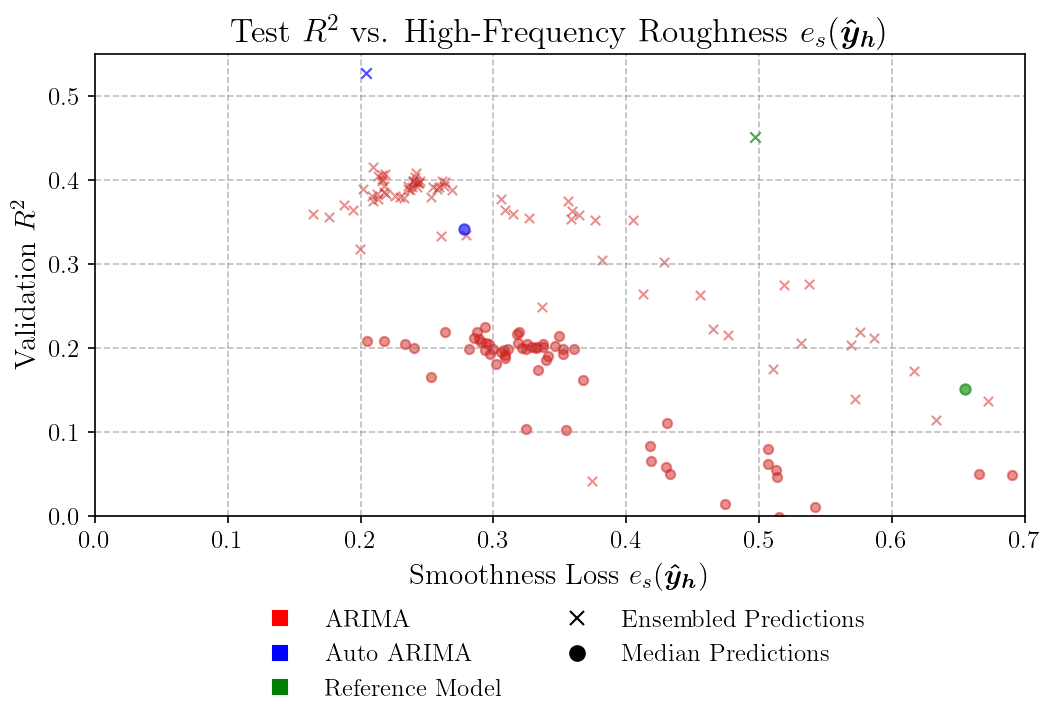

In [314]:
# Plot the results
final_results_df = pd.DataFrame(final_results)
final_results_df['r_squared_mean'] = final_results_df['r_squared_mean'].astype(float)
final_results_df['smoothness_mean'] = final_results_df['smoothness_mean'].astype(float)
final_results_df['r_squared_aggregated'] = final_results_df['r_squared_aggregated'].astype(float)
final_results_df['smoothness_aggregated'] = final_results_df['smoothness_aggregated'].astype(float)

plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(final_results_df['smoothness_mean'], final_results_df['r_squared_mean'], c="#ce2320", marker='o', s=20, alpha=0.5, label='Median Auto ARIMA')
plt.scatter(final_results_df['smoothness_aggregated'], final_results_df['r_squared_aggregated'], c="#ce2320", marker='x', s=20, alpha=0.5, label='Ensembled Auto ARIMA')
plt.scatter(0.27805095438291166, 0.34261413241311045, label='Median Auto ARIMA', color='blue', marker='o', s=25, alpha=0.6) # Can be found in "Smoothing ARIMA auto.ipynb"
plt.scatter(0.2043189456401204, 0.5273255130893598, label='Ensembled Auto ARIMA', color='blue', marker='x', s=25, alpha=0.7) # Can be found in "Smoothing ARIMA auto.ipynb"
plt.scatter(0.6549, 0.1512, label='Median Reference Model', color='green', marker='o', s=25, alpha=0.6)
plt.scatter(0.4968, 0.4515, label='Ensembling on Reference Model', color='green', marker='x', s=25, alpha=0.7)

# Custom legend with color markers for maximum c values
plt.legend(handles=[
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markeredgecolor="red", markersize=7, label='ARIMA'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markeredgecolor="blue", markersize=7, label='Auto ARIMA'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markeredgecolor="green", markersize=7, label='Reference Model'),
    plt.Line2D([0], [0], marker='x', color='w', label='Ensembled Predictions', markerfacecolor='black', markeredgecolor='black', markersize=7),
    plt.Line2D([0], [0], marker='o', color='w', label='Median Predictions', markerfacecolor='black', markeredgecolor='black', markersize=7),
], loc='center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False),

# plt.colorbar(label='Final Validation $R^2$ - Smoothness Loss')
plt.xlabel(r'Smoothness Loss $e_s(\boldsymbol{\hat{y}_h})$')
plt.ylabel('Validation $R^2$')
plt.title(r'Test $R^2$ vs. High-Frequency Roughness $e_s(\boldsymbol{\hat{y}_h})$')
plt.ylim(0, 0.55)
plt.xlim(0, 0.7)
plt.grid()
plt.savefig('data/output_for_paper/plot_postprocessing.pdf', bbox_inches='tight')
plt.show()
